In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize_scalar
from scipy import signal
import statsmodels.api as sm
from scipy.stats import norm
import statsmodels.tsa.stattools as smt
from scipy.optimize import curve_fit

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from statsmodels.tsa.api import VAR
from statsmodels.tsa.tsatools import detrend

### Replication of single-run plots

In [3]:
df_1 = pd.read_csv('validation_samples/valoutput_1.csv')
df_1.head(-10)

,GDP,GDP_growth,C,I,wages,prices,markups,TotDebt,EnDem,U,LIS,Em,EmIndex,RD
0,406997.834113,2.018464,416705.692243,8288.418785,1.232754,1.393067,0.240221,12697.240093,298108.536494,0.0584,0.700071,501173.953496,100.000000,641.814088
1,419971.854852,3.180942,417107.246297,17755.290254,1.238646,1.399878,0.240424,13809.563319,297189.904541,0.0552,0.678291,499707.879142,99.707472,834.631893
2,421222.305830,5.149663,422283.284236,12298.810818,1.230138,1.423228,0.240525,16921.431701,294720.095168,0.0576,0.674123,497326.346960,99.232281,1128.862241
3,427527.032250,3.874742,423708.896114,18402.207432,1.224564,1.408749,0.240654,17297.387768,294981.503755,0.0576,0.664715,497416.050067,99.250180,830.717845
4,428379.028169,-0.506948,426235.651602,20202.249057,1.227115,1.435177,0.240908,18970.118915,297912.079972,0.0464,0.670624,500358.071030,99.837206,1171.682416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,478149.305486,0.899015,528657.739513,7473.983355,1.244248,1.104815,0.309426,7825.822270,393618.924471,0.0036,0.643180,525527.183489,104.859237,950.662675
347,478568.459970,1.189607,530324.547569,10649.248935,1.249179,1.104597,0.309574,4944.499270,394007.486831,0.0024,0.645686,525824.077801,104.918477,941.760308
348,479960.456947,-0.058124,533637.403351,25347.174577,1.244821,1.116264,0.309660,6368.924022,389838.048104,0.0004,0.647173,521953.599748,104.146194,1052.042279
349,499278.598621,-0.934614,540184.204099,25914.335467,1.251662,1.164520,0.309821,12275.408002,383823.977892,0.0044,0.621473,516657.375455,103.089431,1632.507207


In [4]:
T = range(len(df_1.GDP))

In [5]:
def indexnumber(ts):
    return 100 * ts / ts[0]

In [6]:
real_GDP_1 = df_1.GDP / df_1.prices

In [7]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

(Partial) replication of Lamperti et al (2018) fig 2

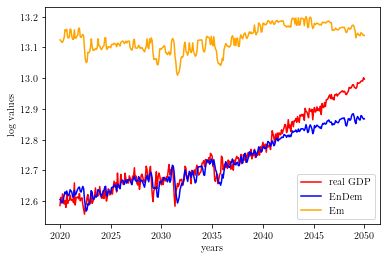

In [8]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# ax[0,0].plot(T, np.log(real_GDP_1))
# ax[0,0].set_xlabel('time')
# ax[0,0].set_ylabel('real GDP (log)')
# ax[0,0].set_title('(a) real GDP')
# ax[0,0].set_xticks(x, years)

# ax[0,1].plot(T, np.log(df_1.EnDem))
# ax[0,1].set_title('(b) energy demand')

# ax[1,0].plot(T, np.log(df_1.Em))
# ax[1,0].set_title('(c) carbon emissions')

x = np.arange(0, 361, 60)
years = np.arange(2020, 2051, 5)

plt.figure(figsize=(6,4))

plt.plot(T, np.log(real_GDP_1), label='real GDP', color='red')
plt.plot(T, np.log(df_1.EnDem), label='EnDem', color='blue')
plt.plot(T, np.log(df_1.Em), label='Em', color='orange')
plt.xticks(ticks=x, labels=years)
plt.xlabel('years')
plt.ylabel('log values')
plt.legend()

plt.show()



(Partial) replication of Lamperti et al (2018) fig 7

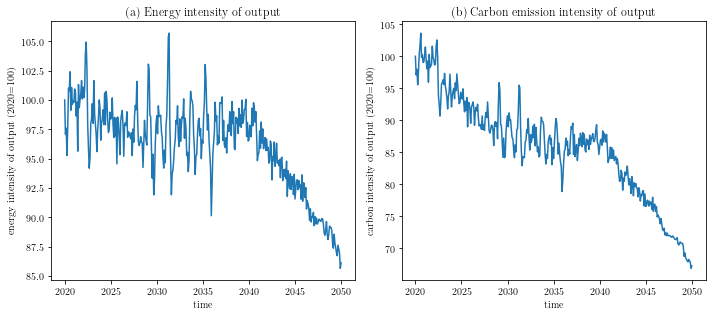

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].plot(T, indexnumber(df_1.EnDem / real_GDP_1))
ax[0].set_xlabel('time')
ax[0].set_ylabel('energy intensity of output (2020=100)')
ax[0].set_title('(a) Energy intensity of output')
ax[0].set_xticks(x, years)

ax[1].plot(T, indexnumber(df_1.Em / real_GDP_1))
ax[1].set_xlabel('time')
ax[1].set_ylabel('carbon intensity of output (2020=100)')
ax[1].set_title('(b) Carbon emission intensity of output')
ax[1].set_xticks(x, years)

plt.tight_layout()
plt.show()

In [10]:
# bk_low = 6
# bk_high = 32
# bk_K = 12

# bk_low = 1.5
# bk_high = 8
# bk_K = 3

bk_low = 18
bk_high = 96
bk_K = 36

(Partial) replication of Lamperti et al (2018) fig 8

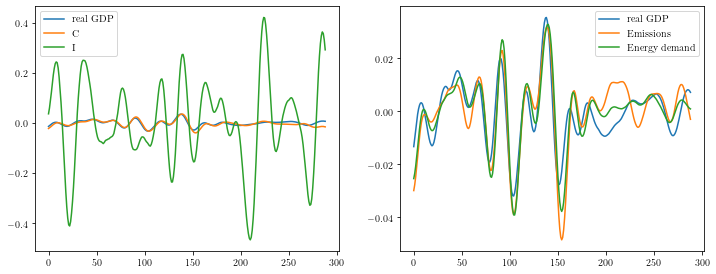

(0.8623506087751817, 8.023228343765042e-87)
(0.38034268045864755, 2.2174130767251072e-11)
(0.8633472986080232, 3.049998553584611e-87)
(0.7845334979691746, 1.625048603411387e-61)


In [11]:
gdp_filtered = sm.tsa.filters.bkfilter(np.log(real_GDP_1), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(df_1.C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(df_1.I), bk_low, bk_high, bk_K)

Em_filtered = sm.tsa.filters.bkfilter(np.log(df_1.Em), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_1.EnDem), bk_low, bk_high, bk_K)

T_filter = range(len(gdp_filtered))

fig, ax = plt.subplots(1, 2, figsize=(12, 4.5))

ax[0].plot(T_filter, gdp_filtered, label='real GDP')
ax[0].plot(T_filter, C_filtered, label='C')
ax[0].plot(T_filter, I_filtered, label='I')
ax[0].legend()

ax[1].plot(T_filter, gdp_filtered, label='real GDP')
ax[1].plot(T_filter, Em_filtered, label='Emissions')
ax[1].plot(T_filter, EnDem_filtered, label='Energy demand')
ax[1].legend()

plt.show()

print(stats.pearsonr(gdp_filtered, C_filtered))
print(stats.pearsonr(gdp_filtered, I_filtered))
print(stats.pearsonr(gdp_filtered, EnDem_filtered))
print(stats.pearsonr(gdp_filtered, Em_filtered))

Dosi et al (2017) fig 2

In [12]:
LIS_filtered = sm.tsa.filters.bkfilter(np.log(df_1.LIS), bk_low, bk_high, bk_K)

print(stats.pearsonr(LIS_filtered, gdp_filtered))

(-0.21588473975277328, 0.0002174470347452024)


In [47]:
# Compute real wages
real_wages = df_1.wages / df_1.prices

real_wages_filtered = sm.tsa.filters.bkfilter(real_wages, bk_low, bk_high, bk_K)
noml_wages_filtered = sm.tsa.filters.bkfilter(df_1.wages, bk_low, bk_high, bk_K)
markups_filtered = sm.tsa.filters.bkfilter(df_1.markups, bk_low, bk_high, bk_K)
U_filtered = sm.tsa.filters.bkfilter(df_1.U, bk_low, bk_high, bk_K)

In [48]:
print(U_filtered)

36     0.025435
37     0.022640
38     0.019069
39     0.014990
40     0.010622
         ...   
320   -0.002899
321   -0.002447
322   -0.001905
323   -0.001322
324   -0.000742
Name: U_cycle, Length: 289, dtype: float64


(-0.4281050307784019, 2.61564889652427e-14)
(-0.27139510056166855, 2.8424585668092156e-06)
(-0.19797967634113078, 0.0007127396439859502)
(-0.8585533496213521, 2.9852730412817133e-85)
(0.531673400083269, 1.7311872321776086e-22)
(0.2254390932841498, 0.0001107551489701571)


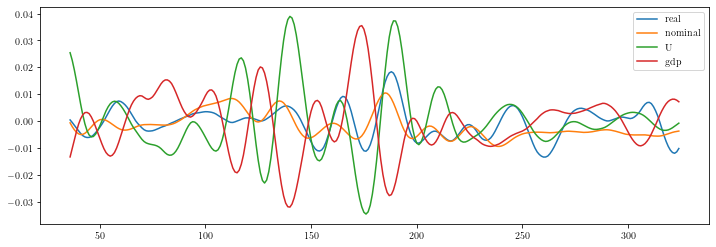

In [49]:


print(stats.pearsonr(gdp_filtered, real_wages_filtered))
print(stats.pearsonr(gdp_filtered, noml_wages_filtered))
print(stats.pearsonr(gdp_filtered, markups_filtered))
print(stats.pearsonr(gdp_filtered, U_filtered))
print(stats.pearsonr(real_wages_filtered, U_filtered))
print(stats.pearsonr(noml_wages_filtered, U_filtered))


plt.figure(figsize=(12,4))
plt.plot(real_wages_filtered, label='real')
plt.plot(noml_wages_filtered, label='nominal')
plt.plot(U_filtered, label='U')
# plt.plot(markups_filtered[:-10], label='$\\mu$')
plt.plot(gdp_filtered, label='gdp')
plt.legend()
plt.show()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Jul, 2022
Time:                     21:59:16
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.2882
Nobs:                     354.000    HQIC:                  -18.4593
Log likelihood:           2308.70    FPE:                8.59318e-09
AIC:                     -18.5724    Det(Omega_mle):     7.99518e-09
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.002828         0.001058            2.674           0.007
L1.y1         1.271435         0.055483           22.916           0.000
L1.y2        -0.234608         0.047115           -4.980           0.000
L2.y1        -0.376163

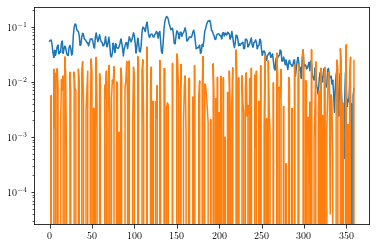

In [79]:
# VAR_data = np.array([df_1.U, detrend(real_wages,1)]).transpose()
VAR_data = np.array([df_1.U[1:], (df_1.wages / df_1.prices).pct_change().replace(np.inf,0)[1:]]).transpose()

plt.plot(VAR_data)
plt.yscale('log')

# plt.plot(detrend(real_wages, 1))
# plt.plot(df_1.U)

res = VAR(VAR_data).fit(6)
print(res.summary())

## Income and wealth distributions

In [230]:
# def powerlaw(x, alpha, xmin=2250):
#     return ((alpha - 1) / xmin) * (x / xmin) ** -alpha

# def alphahat(all_x, xmin):
#     x_i = all_x[np.where(all_x >= xmin)]
#     return 1 + len(x_i) * np.sum(np.log(x_i / xmin))

def powerlaw(x, alpha, beta):
    return beta * x ** (-1 - alpha)

I share: 0.5411263243943245
W share: 0.4515658048664597


/tmp/ipykernel_1177/3074306024.py:51: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(min(dens), max(dens))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1.745786936894839


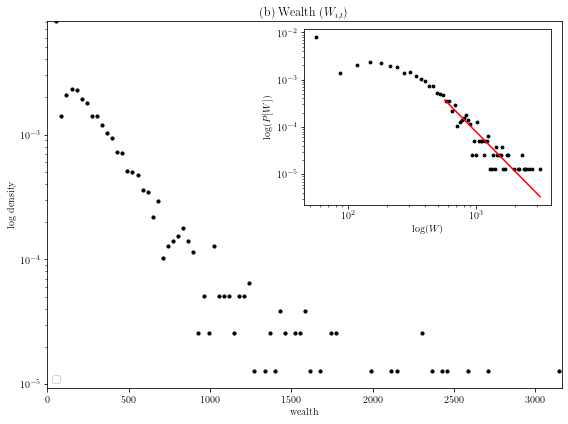

In [269]:
df_I_W = pd.read_csv('../result_data/final_income_dists.csv')

start_60 = round(20/100 * 2500)
end_60 = round(80/100 * 2500)

I_sorted = np.sort(df_I_W.all_I.to_numpy())
I_share = sum(I_sorted[start_60:end_60]) / sum(I_sorted)
print("I share:", I_share)

W_sorted = np.sort(df_I_W.all_W.to_numpy())
W_share = sum(W_sorted[start_60:end_60]) / sum(W_sorted)
print("W share:", W_share)

# fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12, 5))

# dens, bins, _ = ax1.hist(df_I_W.all_I, bins=100, density=True, alpha=0)
# bins1 = bins[:-1]
# bins2 = bins[1:]
# bins = np.mean([bins1, bins2], axis=0)

# ax1.scatter(bins, dens, s=10, color='black')
# ax1.set_title('(a) Income ($I_{i,t}$)')
# ax1.set_yscale('log')
# ax1.axvline(I_sorted[start_60], c='red')
# ax1.axvline(I_sorted[end_60], c='red')
# ax1.set_ylim(min(dens), 0.1)
# ax1.set_ylabel('log density')
# ax1.set_xlabel('income')
# ax1.fill_between([I_sorted[start_60], I_sorted[end_60]], 0, 1, 
#                     color='red', alpha=0.3, label='middle $60\\%$')
# ax1.legend(loc='lower left')

fig, ax = plt.subplots(figsize=(8,6))

dens, bins, _ = ax.hist(df_I_W.all_W, bins=100, density=True, alpha=0.)
bins1 = bins[:-1]
bins2 = bins[1:]
bins = np.mean([bins1, bins2], axis=0)

idx = np.where(dens != 0)[0][12:]
[alpha_hat, beta_hat], [alpha_cov, beta_cov] = curve_fit(powerlaw, bins[idx], dens[idx])
print(alpha_hat)
start_W = 2250

ax.scatter(bins, dens, s=10, color='black')
# ax.plot(W_sorted[2250:], powerlaw(W_sorted[start_W:], alpha_hat, beta_hat), color='red')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_title('(b) Wealth ($W_{i,t}$)')
ax.set_xlim(0, max(df_I_W.all_W))
ax.set_ylim(min(dens), max(dens))

ax.set_ylabel('log density')
ax.set_xlabel('wealth')
# ax2.axvline(W_sorted[start_60], c='red')
# ax2.axvline(W_sorted[end_60], c='red')
# ax2.fill_between([W_sorted[start_60], W_sorted[end_60]], 0, 1, 
#                     color='red', alpha=0.3, label='middle $60\\%$')
ax.legend(loc='lower left')

# print(dens[10:])
# print(dens)

# print(idx)

start_W = 2250

s, loc, scale = stats.lognorm.fit(W_sorted[700:start_W])

axins = ax.inset_axes([0.5, 0.5, 0.48, 0.48])
axins.plot(W_sorted[2250:], powerlaw(W_sorted[start_W:], alpha_hat, beta_hat), color='red')
# axins.plot(W_sorted[700:start_W], stats.lognorm.pdf(W_sorted[700:start_W], s, loc, scale), color='red')
# axins.plot(W_sorted[2250:], stats.powerlaw.pdf(W_sorted[2250:], a, loc, scale))
axins.set_yscale('log')
axins.set_xscale('log')
axins.set_ylabel('$\\log (P[W])$')
axins.set_xlabel('$\\log (W)$')
axins.scatter(bins, dens, s=8, color='black')

plt.tight_layout()
plt.show()

## Aggregate results

In [76]:
def filepath(i):
    return f'validation_samples/valoutput_{i}.csv'

In [77]:
n_MC = 25

df_list = []
for MC_i in range(1, n_MC + 1):
    df_list.append(pd.read_csv(filepath(MC_i)))
df = pd.concat(df_list)

df.head(-10)

,GDP,GDP_growth,C,I,prices,markups,TotDebt,EnDem,U,LIS,Em,EmIndex,RD
0,457700.165670,7.409208,445004.515016,26299.592712,1.445025,0.237096,26083.778479,311134.622173,0.0280,0.677280,502397.529642,100.000000,936.300911
1,446986.111551,-2.510297,447358.242212,14827.300383,1.484126,0.237414,29436.267754,308939.650479,0.0320,0.690798,500231.883290,99.568938,1533.776468
2,436998.713761,0.245503,448204.628025,4317.498807,1.450989,0.237527,32451.041253,307318.499643,0.0464,0.695690,498246.680823,99.173792,1113.874757
3,437236.146492,-3.401904,444527.719293,10626.310617,1.429031,0.237862,27079.177112,311982.789076,0.0396,0.699429,502830.517742,100.086184,684.041243
4,446826.217663,2.492736,442417.855440,22605.957234,1.447512,0.238039,27904.333199,316606.745417,0.0164,0.701004,517598.282889,103.025643,949.368212
...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,438463.256156,2.542037,437731.536451,21438.761211,1.039455,0.304375,27687.028485,397017.337220,0.0220,0.643013,529866.377844,109.164482,883.964240
347,432707.038332,-4.051972,439998.799949,14490.544442,1.065588,0.304773,34836.314834,398203.796095,0.0236,0.650382,530433.912365,109.281407,1476.956459
348,437335.890898,5.784110,441303.563251,16497.161919,1.051727,0.304931,37116.080869,395290.154923,0.0280,0.639642,527519.320995,108.680935,1174.189349
349,449675.713524,1.004723,440183.181344,31308.903691,1.055432,0.305193,33109.036208,400865.281071,0.0096,0.634047,532811.239138,109.771190,1124.643360


In [78]:
real_GDP = df.GDP / df.prices

In [79]:

# gdp_growth = (1 + real_GDP.pct_change()[1:]) ** 3 - 1
gdp_growth = (real_GDP[3:] - real_GDP[:-3]) / real_GDP[:-3]

# Filter out some outliers
gdp_growth = gdp_growth[np.abs(gdp_growth) <= 0.4]


In [80]:
print(len(gdp_growth))
print(gdp_growth)

5635075
0     -0.005595
0     -0.005627
0     -0.005891
0     -0.005739
0     -0.005712
         ...   
360   -0.108182
360   -0.105425
360   -0.109268
360   -0.101448
360   -0.099794
Length: 5635075, dtype: float64


KurtosistestResult(statistic=7.033084342923379, pvalue=2.0201716244408057e-12)


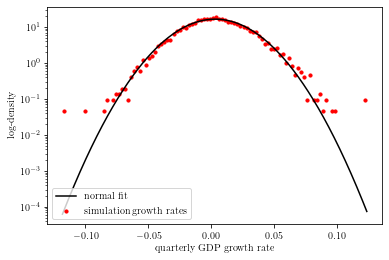

In [94]:
# g = gdp_growth[np.abs(gdp_growth) <= 0.05]

data = df.GDP_growth / 100
# data = gdp_growth

print(stats.kurtosistest(data))

# print(data)

# mu, std = norm.fit(data)

plt.figure(figsize=(6,4))
# plt.hist(gdp_growth, density=True, bins=100)
# plt.xlim(-0.2, 0.2)

# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)

# print(stats.kurtosis(gdp_growth))
x = np.linspace(min(data), max(data), 1000)
dens, bins, _ = plt.hist(data, 100, density=True, alpha=0.)
mu, sigma = stats.norm.fit(data)
best_fit_line = stats.norm.pdf(x, mu, sigma)
bins1 = bins[:-1]
bins2 = bins[1:]

bins = np.mean([bins1, bins2], axis=0)
plt.plot(x, best_fit_line, color='black', label='normal fit')
plt.scatter(bins, dens, s=10, c='red', label='simulation growth rates')
# plt.xlim(-0.15, 0.15)
# plt.ylim(10e-7, 10e2)
plt.legend(loc='lower left')
plt.xlabel('quarterly GDP growth rate')
plt.ylabel('log-density')

plt.yscale('log')

In [82]:
U_filtered = sm.tsa.filters.bkfilter(np.log(df.U), bk_low, bk_high, bk_K)
C_filtered = sm.tsa.filters.bkfilter(np.log(df.C), bk_low, bk_high, bk_K)
I_filtered = sm.tsa.filters.bkfilter(np.log(df.I), bk_low, bk_high, bk_K)
Em_filtered = sm.tsa.filters.bkfilter(np.log(df.Em), bk_low, bk_high, bk_K)
EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df.EnDem), bk_low, bk_high, bk_K)
TotDebt_filtered = sm.tsa.filters.bkfilter(np.log(df.TotDebt), bk_low, bk_high, bk_K)
prices_filtered = sm.tsa.filters.bkfilter(np.log(df.prices), bk_low, bk_high, bk_K)

/home/joosakkerman/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/joosakkerman/.local/lib/python3.8/site-packages/scipy/signal/signaltools.py:507: RuntimeWarning: invalid value encountered in multiply
  ret = ifft(sp1 * sp2, fshape, axes=axes)


(Partial) reproduction of Dosi (2017) fig 3

In [83]:
# Count recession periods
durations = []

recession = False
duration = 0

for g in df.GDP_growth:

    if g < 0:
        if recession:
            duration += 1
        else:
            recession = True
            duration = 1
        
    elif g > 0 and recession:
        recession = False
        durations += [duration]

# print(durations)

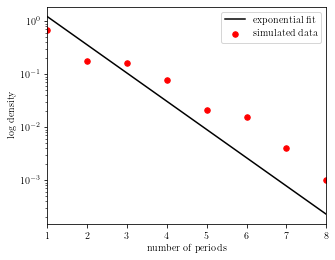

In [84]:
plt.figure(figsize=(5,4))

dens, bins, _ = plt.hist(durations, density=True, bins=max(durations), alpha=0)

loc, scale = stats.expon.fit(durations)
x = np.linspace(1, max(bins), 100)

plt.plot(x, stats.expon.pdf(x, loc, scale), label='exponential fit', c='black')
plt.scatter(np.arange(1, max(bins) + 1), dens, label='simulated data', c='red', s=30, zorder=2)
plt.xlim(1, max(bins))
plt.yscale('log')
plt.xlabel('number of periods')
plt.ylabel('log density')
plt.legend()
plt.show()

(Partial) replication of figure 4 in Lamperti et al (2018)

In [85]:
def compute_correlations(indicator, apply_bk=False, make_real=False, min_lag=-3, max_lag=3):

    all_x = []
    all_y = []

    # gdp_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].GDP / df_list[4].prices), bk_low, bk_high, bk_K)
    # Em_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].Em), bk_low, bk_high, bk_K)
    # EnDem_filtered = sm.tsa.filters.bkfilter(np.log(df_list[4].EnDem), bk_low, bk_high, bk_K)
    # print(stats.pearsonr(gdp_filtered, EnDem_filtered))
    # print(stats.pearsonr(gdp_filtered, Em_filtered))

    for df_part in df_list:

        # Apply filter
        real_GDP =  df_part['GDP'].to_numpy() / df_part['prices'].to_numpy()
        gdp_filtered = sm.tsa.filters.bkfilter(real_GDP, bk_low, bk_high, bk_K)

        # Prepare data
        ind_data = df_part[indicator].to_numpy()
        
        if make_real:
            ind_data = ind_data / df_part['prices'].to_numpy()

        if apply_bk:
            ind_data = sm.tsa.filters.bkfilter(ind_data, bk_low, bk_high, bk_K)

        all_x.extend(ind_data)
        all_y.extend(gdp_filtered)

    # print(all_x)
    # print(all_y)

    ccf_back = smt.ccf(all_x[::-1], all_y[::-1])[1:-min_lag+1][::-1]
    ccf_forw = smt.ccf(all_x, all_y)[:max_lag+1]

    ccf = np.concatenate((ccf_back, ccf_forw))

    # print(indicator)
    # print(ccf)
    
    return ccf

    # r, p = stats.pearsonr(all_x, all_y)
    # all_r.append(r)
    # all_p.append(p)
        
    # return all_r, all_p

compute_correlations('Em', apply_bk=True, make_real=True, min_lag=-12, max_lag=12)

array([-0.01439879, -0.01439577, -0.01152755, -0.00554178,  0.00366161,
        0.01594395,  0.03093382,  0.04806912,  0.06652975,  0.08534717,
        0.10340202,  0.11953633,  0.13257308,  0.14219255,  0.14683535,
        0.14579024,  0.13861879,  0.12526929,  0.10612478,  0.08201426,
        0.05413178,  0.02394949, -0.00690946, -0.03675545, -0.06394584])

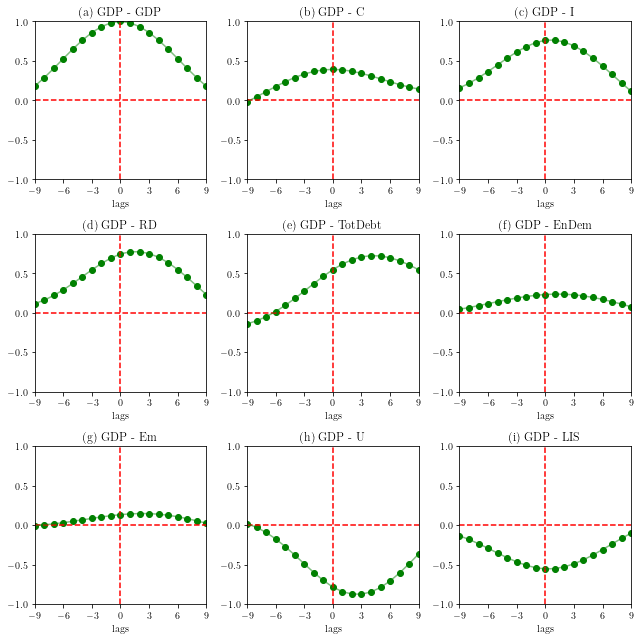

In [86]:
lags = 9
min_lag = -lags
max_lag = lags

indicators = ['GDP', 'C', 'I', 'RD', 'TotDebt', 'EnDem', 'Em', 'U', 'LIS']
lags = np.arange(min_lag, max_lag + 1)

fig, axes = plt.subplots(3,3, figsize=(9, 9))

for i, (indicator, ax) in enumerate(zip(indicators, axes.flatten())):

    fig_nr = chr(i + 97)

    apply_bk = True
    make_real = True
    if indicator == ('markups' or 'U' or 'EnDem' or 'Em' or 'LIS'):
        make_real=False

    all_r = compute_correlations(indicator, apply_bk=apply_bk, make_real=make_real,
                                        min_lag=min_lag, max_lag=max_lag)

    ax.hlines(0, min_lag, max_lag, linestyle='dashed', color='red')
    ax.vlines(0, -1., 1, linestyle='dashed', color='red')

    ax.scatter(lags, all_r, color='green')
    ax.plot(lags, all_r, alpha=0.5, color='green')

    ax.set_ylim(-1., 1.)
    ax.set_xlim(min_lag, max_lag)
    ax.set_xticks(np.linspace(min_lag, max_lag, 7))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_title(f'({fig_nr}) GDP - {indicator}')
    ax.set_xlabel('lags')

plt.tight_layout()
plt.show()

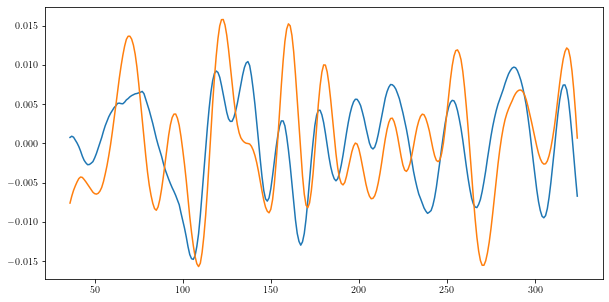

(0.47558636786932035, 1.0233711478232597e-17)


In [87]:
real_GDP_0 = df_list[0].GDP / df_list[0].prices

real_GDP_0 = sm.tsa.filters.bkfilter(np.log(real_GDP_0), bk_low, bk_high, bk_K)
Em_filtered = sm.tsa.filters.bkfilter(np.log(df_list[0].Em), bk_low, bk_high, bk_K)
# cycle_gdp, trend_gdp = sm.tsa.filters.hpfilter(real_GDP_0, 129600)
# cycle_em, trend_cm = sm.tsa.filters.hpfilter(df_list[0].Em, 129600)

plt.figure(figsize=(10, 5))

plt.plot(real_GDP_0)
plt.plot(Em_filtered)
# plt.plot(cycle_gdp)
# plt.plot(cycle_em)

plt.show()

print(stats.pearsonr(real_GDP_0, Em_filtered))

In [ ]:
df.corr()

,GDP,GDP_growth,C,I,prices,markups,TotDebt,EnDem,U,Em,EmIndex,RD
GDP,1.000000,0.221135,0.813161,0.528144,0.551441,-0.454599,0.421049,-0.490290,-0.323773,-0.256723,0.002629,0.259236
GDP_growth,0.221135,1.000000,0.002570,0.363787,-0.023625,0.007852,-0.063479,-0.007590,0.189189,-0.034400,-0.027746,-0.003600
C,0.813161,0.002570,1.000000,0.158498,0.377121,-0.300440,0.412758,-0.233538,-0.317394,0.033236,0.284520,0.187278
I,0.528144,0.363787,0.158498,1.000000,0.107986,-0.004168,0.248093,-0.012505,-0.320681,0.132338,-0.002245,0.526222
prices,0.551441,-0.023625,0.377121,0.107986,1.000000,-0.869675,0.238322,-0.931306,-0.125690,-0.438099,-0.416487,-0.132325
markups,-0.454599,0.007852,-0.300440,-0.004168,-0.869675,1.000000,-0.040962,0.877894,0.175495,0.539164,0.394921,0.255720
TotDebt,0.421049,-0.063479,0.412758,0.248093,0.238322,-0.040962,1.000000,-0.154793,-0.296471,0.075685,-0.192922,0.351738
EnDem,-0.490290,-0.007590,-0.233538,-0.012505,-0.931306,0.877894,-0.154793,1.000000,0.034598,0.678589,0.529248,0.263404
U,-0.323773,0.189189,-0.317394,-0.320681,-0.125690,0.175495,-0.296471,0.034598,1.000000,-0.003740,-0.071768,-0.191334
Em,-0.256723,-0.034400,0.033236,0.132338,-0.438099,0.539164,0.075685,0.678589,-0.003740,1.000000,0.544236,0.340744


In [ ]:
filtered_series ={
    'GDP': sm.tsa.filters.bkfilter(np.log(df.GDP / df.prices), bk_low, bk_high, bk_K),
    '$\\hat{\\mu}$': sm.tsa.filters.bkfilter(df.markups, bk_low, bk_high, bk_K),
    'I': I_filtered.to_numpy(),
    'C': C_filtered.to_numpy(),
    'U': U_filtered.to_numpy(),
    'TotDebt': TotDebt_filtered.to_numpy(),
    'EnDem': EnDem_filtered.to_numpy(),
    'Em': Em_filtered.to_numpy()
}

df_filtered = pd.DataFrame(filtered_series)

ValueError: All arrays must be of the same length

In [ ]:
import seaborn as sb
# corr = df.corr()

plt.figure(figsize=(6,5))

sb.heatmap(df_filtered.corr(), cmap="vlag", annot=True)

plt.tight_layout()
plt.show()

NameError: name 'df_filtered' is not defined

<Figure size 432x360 with 0 Axes>